In [1]:
import geopandas as gpd
from tkinter import filedialog,messagebox
import tkinter as tk
import pandas as pd
import sys,os

from helpers_linear_analysis import *
from get_section_lines import *
from helpers_sectional_analysis import *

In [2]:
## output folder path
output_dir = "D:/2_Analytics/6_plan_vs_actual/8_sept_outputs_4"
os.makedirs(output_dir, exist_ok=True)

## actual data from site (excavation and dump)
actual_excavation_inputs = "D:/2_Analytics/6_plan_vs_actual/All_Inputs_UTCL/Actual Dump & EXAVATION  area/Actual Excavated area.shp"
actual_dump_inputs = "D:/2_Analytics/6_plan_vs_actual/All_Inputs_UTCL/Actual Dump & EXAVATION  area/Actual Dump area.shp"

## planned/proposed data from client 
planned_excavtaion_inputs = "D:/2_Analytics/6_plan_vs_actual/All_Inputs_UTCL/Proposed Dump & Pit Area from client/Proposed PIT AREA from client.shp"
planned_dump_inputs = "D:/2_Analytics/6_plan_vs_actual/All_Inputs_UTCL/Proposed Dump & Pit Area from client/Proposed Dump from client.shp"


## dwg file and ODA convertor
input_folder_dwg_file = "D:/2_Analytics/6_plan_vs_actual/raw_data_dwg_file/dwg_file"
oda_exe = "C:/Program Files/ODA/ODAFileConverter 26.7.0/ODAFileConverter.exe"
section_line_folder = os.path.join(output_dir, "section_lines")
os.makedirs(section_line_folder, exist_ok=True)



### sectional inputs 
## Dtms
dtm_itr1_path = "D:/2_Analytics/6_plan_vs_actual/UTCL_data/UTCL_data/DEMs/DEM_itr_1.tif"
dtm_itr1_year_ip =  2024                              
dtm_itr1_year_ip = dtm_itr1_year_ip if dtm_itr1_year_ip else "itr1"

dtm_itr2_path = "D:/2_Analytics/6_plan_vs_actual/UTCL_data/UTCL_data/DEMs/DEM_itr_2.tif"
dtm_itr2_year_ip = 2025                              
dtm_itr2_year_ip = dtm_itr2_year_ip if dtm_itr2_year_ip else "itr2"




## read the 1st line in section line 

section_lines_gdf = gpd.read_file("D:/2_Analytics/6_plan_vs_actual/8_sept_outputs_4/section_lines/LINES_with_start_end_text.shp")

sectional_analysis_output_path = os.path.join(output_dir,"sectional_output")
os.makedirs(sectional_analysis_output_path, exist_ok=True)


Fetch the section names

In [35]:
first_line_gdf = section_lines_gdf.iloc[[0]]

Get linear deviation outputs

In [19]:
## get output from linear analysis 
(done_exv, not_done_exv, unplanned_exv, done_dump, not_done_dump, unplanned_dump) = get_linear_outputs(output_dir)
print(done_exv)

D:/2_Analytics/6_plan_vs_actual/8_sept_outputs_4\shape_file_outputs\planned_and_done_excavation.shp


Intersect the section line with polygons

In [5]:
def intersect_line_with_polygons_return_separately(line_gdf, 
                                                   output_folder_path: str,
                                                   section_name: str,
                                                   planned_and_done_excavation_path: str = None,
                                                   unplanned_and_done_excavation_path: str = None,
                                                   planned_and_used_dump_path: str = None,
                                                   unplanned_and_used_dump_path: str = None):
    def process(name, poly_path):
        output_path = os.path.join(output_folder_path, f"section_{section_name}_{name}.shp")

        # Return empty GeoDataFrame if path is None or file does not exist
        if poly_path is None or not os.path.exists(poly_path):
            print(f"{name}: File path is None or does not exist.")
            empty_gdf = gpd.GeoDataFrame(geometry=[], crs=line_gdf.crs)
            empty_gdf.to_file(output_path)
            return empty_gdf

        poly_gdf = gpd.read_file(poly_path)
        if poly_gdf.empty:
            print(f"{name}: Polygon file is empty.")
            empty_gdf = gpd.GeoDataFrame(geometry=[], crs=line_gdf.crs)
            empty_gdf.to_file(output_path)
            return empty_gdf

        # Reproject to match CRS
        if poly_gdf.crs != line_gdf.crs:
            poly_gdf = poly_gdf.to_crs(line_gdf.crs)

        poly_union = poly_gdf.unary_union
        intersection = line_geom.intersection(poly_union)

        segments = []
        if intersection.is_empty:
            print(f"{name}: No intersection.")
        elif isinstance(intersection, LineString):
            segments.append(intersection)
        elif isinstance(intersection, MultiLineString):
            segments.extend(intersection.geoms)
        else:
            print(f"{name}: Unsupported geometry type {type(intersection)}")

        # Prepare GeoDataFrame
        intersect_gdf = gpd.GeoDataFrame(geometry=segments, crs=poly_gdf.crs)

        if not intersect_gdf.empty:
            intersect_gdf["temp_id"] = intersect_gdf.index
            intersect_gdf = gpd.sjoin(intersect_gdf, poly_gdf[["geometry", "AREA_NAME"]], how="left", predicate="intersects")
            intersect_gdf = intersect_gdf.drop(columns=["index_right", "temp_id"])

        # Save output
        intersect_gdf.to_file(output_path)
        return intersect_gdf

    # Ensure only one line feature is present
    if len(line_gdf) != 1:
        raise ValueError("Line GeoDataFrame must contain exactly one feature.")
    line_geom = line_gdf.geometry.iloc[0]

    # Process each layer
    lines_planned_and_done_excavation = process("planned_and_done_excavation", planned_and_done_excavation_path)
    lines_unplanned_and_done_excavation = process("unplanned_and_done_excavation", unplanned_and_done_excavation_path)
    lines_planned_and_used_dump = process("planned_and_used_dump", planned_and_used_dump_path)
    lines_unplanned_and_used_dump = process("unplanned_and_used_dump", unplanned_and_used_dump_path)

    return (
        lines_planned_and_done_excavation,
        lines_unplanned_and_done_excavation,
        lines_planned_and_used_dump,
        lines_unplanned_and_used_dump
    ), section_name



(lines_planned_and_done_excavation,
lines_unplanned_and_done_excavation,
lines_planned_and_used_dump,
lines_unplanned_and_used_dump), section_name = intersect_line_with_polygons_return_separately(
                                                line_gdf=first_line_gdf,
                                                output_folder_path= sectional_analysis_output_path,
                                                section_name= "J J'",
                                                planned_and_done_excavation_path = done_exv,
                                                unplanned_and_done_excavation_path = unplanned_exv,
                                                planned_and_used_dump_path = done_dump,
                                                unplanned_and_used_dump_path  = unplanned_dump)       


# Create save folder (if not exists)
save_dir = os.path.join(sectional_analysis_output_path, f"section_{section_name}")
os.makedirs(save_dir, exist_ok=True)

# Save each GeoDataFrame as a shapefile
lines_planned_and_done_excavation.to_file(os.path.join(save_dir, "planned_and_done_excavation.shp"))
lines_unplanned_and_done_excavation.to_file(os.path.join(save_dir, "unplanned_and_done_excavation.shp"))
lines_planned_and_used_dump.to_file(os.path.join(save_dir, "planned_and_used_dump.shp"))
lines_unplanned_and_used_dump.to_file(os.path.join(save_dir, "unplanned_and_used_dump.shp"))



planned_and_used_dump: File path is None or does not exist.
unplanned_and_used_dump: No intersection.


C:\Users\MansiPradipKoshti\AppData\Local\Temp\ipykernel_29300\2011604850.py:29: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  poly_union = poly_gdf.unary_union
C:\Users\MansiPradipKoshti\AppData\Local\Temp\ipykernel_29300\2011604850.py:29: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  poly_union = poly_gdf.unary_union
C:\Users\MansiPradipKoshti\AppData\Local\Temp\ipykernel_29300\2011604850.py:29: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  poly_union = poly_gdf.unary_union


Extract the Elevation 

In [ ]:
def extract_segment_df(intersect_line, clipped_line_gdf, dtm1_path, dtm2_path):
    gdf = intersect_line
    if gdf.empty:
        return pd.DataFrame()  # Return empty if no data

    if gdf.crs != clipped_line_gdf.crs:
        gdf = gdf.to_crs(clipped_line_gdf.crs)

    main_line = clipped_line_gdf.geometry.iloc[0]
    segment_points = []

    with rasterio.open(dtm1_path) as dtm1, rasterio.open(dtm2_path) as dtm2:
        for idx, seg in enumerate(gdf.geometry):
            area_name = gdf.iloc[idx].get("AREA_NAME", None)
            for pt in [seg.interpolate(0), seg.interpolate(seg.length)]:
                chainage = main_line.project(pt)
                elev1 = elevation_at_point(dtm1, pt.x, pt.y)
                elev2 = elevation_at_point(dtm2, pt.x, pt.y)
                segment_points.append({
                    "chainage": chainage,
                    "elevation_itr1": elev1,
                    "elevation_itr2": elev2,
                    "AREA_NAME": area_name
                })
    #print(segment_points)
    return pd.DataFrame(segment_points)


# Extract elevation data from each DTM
planned_and_done_excavation = extract_segment_df(lines_planned_and_done_excavation, first_line_gdf , dtm_itr1_path, dtm_itr2_path)
unplanned_and_done_excavation = extract_segment_df(lines_unplanned_and_done_excavation, first_line_gdf, dtm_itr1_path, dtm_itr2_path)
planned_and_used_dump = extract_segment_df(lines_planned_and_used_dump, first_line_gdf, dtm_itr1_path, dtm_itr2_path)
unplanned_and_used_dump = extract_segment_df(lines_unplanned_and_used_dump, first_line_gdf, dtm_itr1_path, dtm_itr2_path)


#print(planned_and_done_excavation) 
print(unplanned_and_done_excavation)
# print(planned_and_used_dump)
# print(unplanned_and_used_dump)

     chainage  elevation_itr1  elevation_itr2  \
0  392.683393      214.086411      213.545532   
1  468.492413      203.703644      203.268387   
2  480.204554      200.737579      200.335526   
3  487.215552      196.689346      196.194519   
4  505.493012      195.831451      195.395508   
5  533.577862      187.453964      186.960587   

                              AREA_NAME  
0  unplanned_and_done_excavation_area_8  
1  unplanned_and_done_excavation_area_8  
2  unplanned_and_done_excavation_area_8  
3  unplanned_and_done_excavation_area_8  
4  unplanned_and_done_excavation_area_9  
5  unplanned_and_done_excavation_area_9  


In [27]:
def analyze_section_and_match(
    dtm_itr1: str,
    dtm_itr2: str,
    section_shp: str,
    line_gdf_shp: str,
    interval: float = 0.01
) -> None:
 
    # --- 1) open dtm_itr1 to obtain target CRS (assume dtm_itr1 and dtm_itr2 share CRS) ---
    with rasterio.open(dtm_itr1) as src:
        dtm_crs = src.crs

    # --- 2) read section shapefile and ensure linestring geometry ---
    section_gdf = gpd.read_file(section_shp)
    print(f"Section shapefile read: {section_shp}")
    print(f"Number of features in section shapefile: {len(section_gdf)}")

    if len(section_gdf) == 0:
        raise ValueError("Section shapefile contains no features.")

    # Validate geometries are LineString or MultiLineString
    geom_types = section_gdf.geometry.geom_type.unique()
    if not set(geom_types).issubset({"LineString", "MultiLineString"}):
        raise ValueError(f"Section shapefile must contain LineString/MultiLineString geometries. Found: {geom_types}")

    # Take first feature and get a single LineString
    first_geom = section_gdf.geometry.iloc[0]
    if isinstance(first_geom, MultiLineString):
        # unify into a single LineString by taking unary_union and the longest piece
        union = unary_union(first_geom)
        if union.geom_type == "MultiLineString":
            # pick longest component
            pieces = list(union)
            first_geom = max(pieces, key=lambda g: g.length)
        else:
            first_geom = union  # might be LineString

    section_line: LineString = first_geom  # now a LineString

    # Reproject section_line to dtm_crs if needed
    if section_gdf.crs is not None and dtm_crs is not None and section_gdf.crs != dtm_crs:
        # reproject using geopandas
        section_gdf_proj = section_gdf.to_crs(dtm_crs)
        first_geom = section_gdf_proj.geometry.iloc[0]
        if isinstance(first_geom, MultiLineString):
            first_geom = max(list(first_geom), key=lambda g: g.length)
        section_line = first_geom
    else:
        # if no CRS on section_gdf, assume it's already in dtm_crs (best-effort)
        # create a GeoSeries to attach dtm_crs (not strictly necessary, but helpful)
        # NOTE: we do not modify input file; this is only internal assumption
        pass

    # --- 3) interpolate the section line at the requested interval ---
    total_len = section_line.length
    if total_len == 0:
        raise ValueError("Selected section line has zero length.")

    # build chainages: include start 0.0 and final point at total_len
    num_steps = int(np.floor(total_len / interval))
    distances = [i * interval for i in range(num_steps + 1)]
    if distances[-1] < total_len:
        distances.append(total_len)

    points = []
    for d in distances:
        pt = section_line.interpolate(d)
        points.append((d, pt.x, pt.y))

    df = pd.DataFrame(points, columns=["chainage", "x", "y"])

    # --- 4) fetch elevations from both DTMs using user's elevation_at_point function ---
    elev1_list = []
    elev2_list = []
    for idx, row in df.iterrows():
        x, y = float(row["x"]), float(row["y"])
        #print(x,y)
        try:
            e1 = elevation_at_point(dtm_itr1, x, y)
            print(e1)
        except Exception as ex:
            # if elevation_at_point fails for any point, store nan but continue
            #print(f"Warning: elevation_at_point failed for dtm_itr1 at ({x},{y}): {ex}")
            e1 = float("nan")
        try:
            e2 = elevation_at_point(dtm_itr2, x, y)
            print(e2)
        except Exception as ex:
            #print(f"Warning: elevation_at_point failed for dtm_itr2 at ({x},{y}): {ex}")
            e2 = float("nan")
        elev1_list.append(float(e1) if e1 is not None else float("nan"))
        elev2_list.append(float(e2) if e2 is not None else float("nan"))

    df["elevation_itr1"] = elev1_list
    df["elevation_itr2"] = elev2_list

    # For convenience print small summary of DataFrame
    print("Sample of interpolated points and elevations (first 10 rows):")
    print(df.head(10).to_string(index=False))

    # --- 5) read line_gdf and ensure linestring-only, print number of features ---
    line_gdf = gpd.read_file(line_gdf_shp)
    print(f"Line GDF read: {line_gdf_shp}")
    print(f"Number of features in line_gdf: {len(line_gdf)}")

    if len(line_gdf) == 0:
        print("line_gdf contains zero features; nothing to match.")
        return None

    # Ensure geometry types in line_gdf are LineString / MultiLineString
    lg_geom_types = set(line_gdf.geometry.geom_type.unique())
    if not lg_geom_types.issubset({"LineString", "MultiLineString"}):
        raise ValueError(f"line_gdf must contain LineString/MultiLineString geometries only. Found: {lg_geom_types}")

    # Reproject line_gdf to dtm_crs if needed
    if line_gdf.crs is not None and dtm_crs is not None and line_gdf.crs != dtm_crs:
        line_gdf = line_gdf.to_crs(dtm_crs)
    elif line_gdf.crs is None:
        # assume it is already in dtm_crs (best-effort)
        line_gdf = line_gdf.set_crs(dtm_crs, allow_override=True)

    # --- 6) find where line_gdf lies on the section_line ---
    # We'll compute intersection between section_line and each line_gdf feature.
    # For each feature that intersects, print the intersection start and end coordinates and their chainages.
    print("\nMatching segments of line_gdf located on section_line (for each feature):")
    matched_any = False
    for idx, row in line_gdf.iterrows():
        geom = row.geometry
        inter = geom.intersection(section_line)  # intersection could be Point, LineString, MultiLineString, empty

        if inter.is_empty:
            # no intersection for this feature
            continue

        # Normalize to list of LineStrings for processing
        segments = []
        if isinstance(inter, LineString):
            segments = [inter]
        elif isinstance(inter, MultiLineString):
            segments = list(inter)
        else:
            # if intersection is a Point or GeometryCollection, try to ignore (no length)
            # but if it's a Point, we can still compute chainage of that single point
            try:
                if inter.geom_type == "Point":
                    # treat point as zero-length segment: start=end=the point
                    p = inter
                    segments = []
                    start_chain = section_line.project(p)
                    x, y = p.x, p.y
                    print(f"Feature idx {idx}: intersection is a point at ({x:.6f}, {y:.6f}), chainage {start_chain:.6f}")
                    matched_any = True
                    continue
            except Exception:
                continue

        # For each intersecting segment, compute start/end coordinates and chainages
        for seg in segments:
            if seg.length == 0:
                # degenerate skip
                continue
            start_pt = Point(seg.coords[0])
            end_pt = Point(seg.coords[-1])
            start_chain = section_line.project(start_pt)
            end_chain = section_line.project(end_pt)
            print(
                f"Feature idx {idx}: segment start ({start_pt.x:.6f}, {start_pt.y:.6f}), "
                f"chainage {start_chain:.6f}  -> "
                f"end ({end_pt.x:.6f}, {end_pt.y:.6f}), chainage {end_chain:.6f}"
            )
            matched_any = True

    if not matched_any:
        print("No segments of line_gdf were found to intersect the section_line.")


    return None


analyze_section_and_match(dtm_itr1 = dtm_itr1_path, dtm_itr2 = dtm_itr2_path, 
                          section_shp="D:/2_Analytics/6_plan_vs_actual/8_sept_outputs_4/section_lines/LINES_with_start_end_text.shp", 
                          line_gdf_shp="D:/2_Analytics/6_plan_vs_actual/8_sept_outputs_4/sectional_output/section_J J'/planned_and_done_excavation.shp", 
                          interval=0.01) 


Section shapefile read: D:/2_Analytics/6_plan_vs_actual/8_sept_outputs_4/section_lines/LINES_with_start_end_text.shp
Number of features in section shapefile: 18
Sample of interpolated points and elevations (first 10 rows):
 chainage             x            y  elevation_itr1  elevation_itr2
     0.00 306068.317569 2.189345e+06             NaN             NaN
     0.01 306068.320954 2.189345e+06             NaN             NaN
     0.02 306068.324338 2.189345e+06             NaN             NaN
     0.03 306068.327723 2.189345e+06             NaN             NaN
     0.04 306068.331107 2.189345e+06             NaN             NaN
     0.05 306068.334492 2.189345e+06             NaN             NaN
     0.06 306068.337876 2.189345e+06             NaN             NaN
     0.07 306068.341261 2.189345e+06             NaN             NaN
     0.08 306068.344646 2.189345e+06             NaN             NaN
     0.09 306068.348030 2.189345e+06             NaN             NaN
Line GDF read: D:/

In [ ]:
# ---------- Step 1: Elevation querying helper ----------
def elevation_at_point(dtm_src, x, y):
    """Query elevation value from DTM raster at (x, y) location."""
    q_ele = list(dtm_src.sample([(x, y)]))[0][0]
    return q_ele

# ---------- Step 2: Elevation sampling function ----------
def get_elevation_points_from_lines(dtm_path: str, clipped_gdf, interval: float = 0.01):
    """
    For each point interpolated along lines, fetch elevation from DTM.
    Returns: List of (x, y, z) tuples.
    """
    lines_gdf = clipped_gdf
    lines_gdf = lines_gdf.iloc[[0]] 

    print(lines_gdf)

    with rasterio.open(dtm_path) as dtm_src:
        if lines_gdf.crs != dtm_src.crs:
            print("Reprojecting line geometries to match DTM CRS...")
            lines_gdf = lines_gdf.to_crs(dtm_src.crs)

        points_with_elevation = []

        for geom in lines_gdf.geometry:
            if isinstance(geom, LineString):
                length = geom.length
                num_points = int(length // interval) + 1
                distances = [i * interval for i in range(num_points + 1)]

                for d in distances:
                    pt = geom.interpolate(d)
                    x, y = pt.x, pt.y
                    z = elevation_at_point(dtm_src, x, y)
                    points_with_elevation.append((x, y, z))

        return points_with_elevation



# Get elevation profiles
elevations_itr1 = get_elevation_points_from_lines(dtm_itr1_path, first_line_gdf, interval=0.01)
elevations_itr2 = get_elevation_points_from_lines(dtm_itr2_path, first_line_gdf, interval=0.01)




                             start                              end  \
0  (306068.317569, 2189344.542972)  (306590.247178, 2190795.616916)   

                 start_text                   end_text  \
0  {\fArial|b0|i0|c0|p34;E}  {\fArial|b0|i0|c0|p34;E'}   

                                            geometry  
0  LINESTRING (306068.318 2189344.543, 306590.247...  
                             start                              end  \
0  (306068.317569, 2189344.542972)  (306590.247178, 2190795.616916)   

                 start_text                   end_text  \
0  {\fArial|b0|i0|c0|p34;E}  {\fArial|b0|i0|c0|p34;E'}   

                                            geometry  
0  LINESTRING (306068.318 2189344.543, 306590.247...  
                             start                              end  \
0  (306068.317569, 2189344.542972)  (306590.247178, 2190795.616916)   

                 start_text                   end_text  \
0  {\fArial|b0|i0|c0|p34;E}  {\fArial|b0|i0|c0|p34;E'}   



     chainage  elevation_itr1  elevation_itr2  \
0  392.683393      214.086411      213.545532   
1  468.492413      203.703644      203.268387   
2  480.204554      200.737579      200.335526   
3  487.215552      196.689346      196.194519   
4  505.493012      195.831451      195.395508   
5  533.577862      187.453964      186.960587   

                              AREA_NAME  
0  unplanned_and_done_excavation_area_8  
1  unplanned_and_done_excavation_area_8  
2  unplanned_and_done_excavation_area_8  
3  unplanned_and_done_excavation_area_8  
4  unplanned_and_done_excavation_area_9  
5  unplanned_and_done_excavation_area_9  


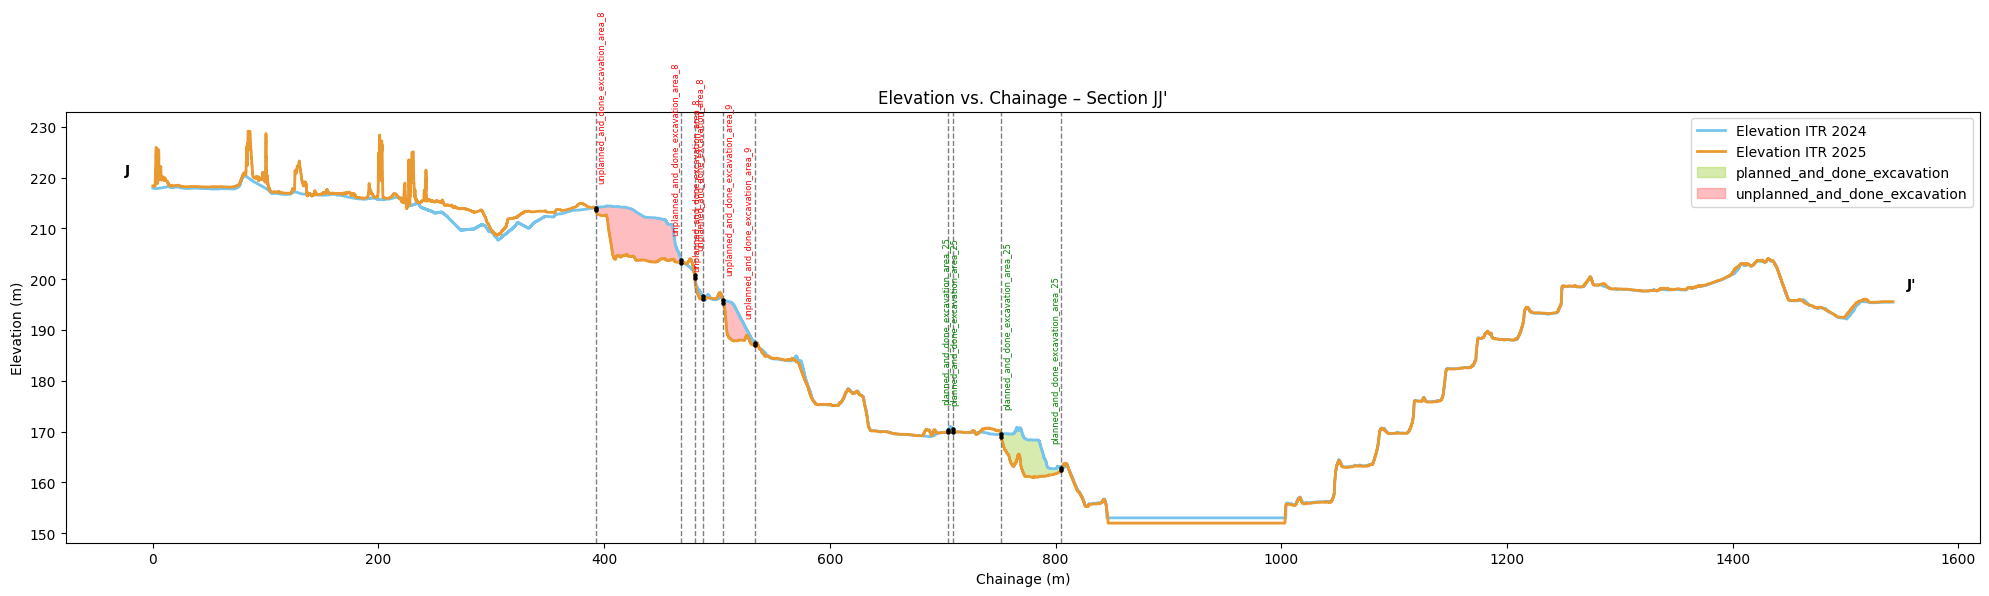

In [17]:
# Convert elevation to DataFrame
df1 = pd.DataFrame(elevations_itr1, columns=["x", "y", "z"])
df1["chainage"] = [0.01 * i for i in range(len(df1))]


df2 = pd.DataFrame(elevations_itr2, columns=["x", "y", "z"])
df2["chainage"] = [0.01 * i for i in range(len(df2))]

print(unplanned_and_done_excavation)

segment_data_dict = {
            "planned_and_done_excavation": (planned_and_done_excavation, "green"),
            "unplanned_and_done_excavation": (unplanned_and_done_excavation, "red"),
            "planned_and_used_dump": (planned_and_used_dump, "green"),
            "unplanned_and_used_dump": (unplanned_and_used_dump, "red"),
        }

def plot_multiple_intersections_on_elevation(df1, dtm_itr1_year_ip, df2, dtm_itr2_year_ip, segment_data_dict, section_name, output_folder_path):
    import matplotlib.pyplot as plt
    import pandas as pd
    import os

    start_label, end_label = section_name.split("_")
    fig, ax = plt.subplots(figsize=(20, 6))
    fig.patch.set_facecolor('white')  # Figure background
    ax.set_facecolor('white')         # Plot (axes) background

    # Plot base elevation profiles
    ax.plot(df1["chainage"], df1["z"], label=f"Elevation ITR {dtm_itr1_year_ip}", color="#76c3ec", linewidth=2)
    ax.plot(df2["chainage"], df2["z"], label=f"Elevation ITR {dtm_itr2_year_ip}", color="#e99930", linewidth=2)

    intersection_chainages = []

    for label, (segment_df, _) in segment_data_dict.items():
        if segment_df is None or segment_df.empty:
            continue

        # Plot the points
        ax.scatter(segment_df["chainage"], segment_df["elevation_itr1"], color="black", s=5, zorder=5)
        ax.scatter(segment_df["chainage"], segment_df["elevation_itr2"], color="black", s=5, zorder=5)

        for idx, row in segment_df.iterrows():
            area_name = str(row.get("AREA_NAME", ""))
            ch = row["chainage"]
            z = row["elevation_itr1"]

            # Decide fill color (keep original logic)
            if area_name.startswith("planned_and_done") or area_name.startswith("planned_and_done"):
                fill_color = "#9ACD32"  # planned
                text_color = "#008000"  # dark green
            elif area_name.startswith("unplanned_and_done") or area_name.startswith("unplanned_and_done"):
                fill_color = "#fd5c63"  # unplanned
                text_color = "#FF0000"  # dark redp
            else:
                fill_color = "gray"
                text_color = "black"

            # Annotation above the point
            if pd.notnull(area_name):
                ha = 'left' if idx % 2 == 0 else 'right'
                offset_x = 1.2 if idx % 2 == 0 else -1

                ax.annotate(area_name, xy=(ch, z), xytext=(offset_x, 18), textcoords='offset points',
                            fontsize=6, color=text_color, ha=ha, va='bottom', rotation=90)

            # Collect chainage for vertical line
            intersection_chainages.append(ch)

        # Fill area between elevation lines with original logic
        for i in range(0, len(segment_df), 2):
            if i + 1 >= len(segment_df):
                continue

            ch_start = min(segment_df.iloc[i]["chainage"], segment_df.iloc[i+1]["chainage"])
            ch_end   = max(segment_df.iloc[i]["chainage"], segment_df.iloc[i+1]["chainage"])

            mask = (df1["chainage"] >= ch_start) & (df1["chainage"] <= ch_end)
            x = df1.loc[mask, "chainage"]
            y1 = df1.loc[mask, "z"]
            y2 = df2.loc[mask, "z"]

            ax.fill_between(x, y1, y2, color=fill_color, alpha=0.4, label=label if i == 0 else None)

    # Draw vertical dashed lines in cyan only
    for ch in intersection_chainages:
        ax.axvline(x=ch, color='gray', linestyle='--', linewidth=1)

    # Add section labels
    ax.annotate(start_label, xy=(df1["chainage"].iloc[0], df1["z"].iloc[0]),
                textcoords="offset points", xytext=(-20, 10), fontsize=10, color="Black", weight='bold')
    ax.annotate(end_label, xy=(df1["chainage"].iloc[-1], df1["z"].iloc[-1]),
                textcoords="offset points", xytext=(10, 10), fontsize=10, color="Black", weight='bold')

    ax.set_xlabel("Chainage (m)")
    ax.set_ylabel("Elevation (m)")
    new_section_name = section_name.replace("_", "")
    ax.set_title(f"Elevation vs. Chainage – Section {new_section_name}")
    ax.grid(False)
    ax.legend()
    plt.tight_layout()

    # Save plot
    section_folder_name = f"section_{section_name}_plot"
    output_path = os.path.join(output_folder_path, section_folder_name)
    os.makedirs(output_path, exist_ok=True)
    file_path = os.path.join(output_path, f"{section_folder_name}_plot.png")
    #plt.savefig(file_path, dpi=300, facecolor='white')
    #plt.close()
    plt.show()
    
    return None

# Plot and save
plot_multiple_intersections_on_elevation(
    df1, dtm_itr1_year_ip, 
    df2, dtm_itr2_year_ip, 
    segment_data_dict,
    section_name="J_J'",
    output_folder_path=sectional_analysis_output_path
        )

In [18]:
print(planned_and_done_excavation)
print()
print(unplanned_and_done_excavation)
print()
print(planned_and_used_dump)
print()
print(unplanned_and_used_dump)

     chainage  elevation_itr1  elevation_itr2  \
0  705.142969      170.340271      169.859634   
1  708.712463      170.478546      169.923157   
2  751.759589      169.564377      169.008804   
3  805.298461      162.917358      162.460648   

                             AREA_NAME  
0  planned_and_done_excavation_area_25  
1  planned_and_done_excavation_area_25  
2  planned_and_done_excavation_area_25  
3  planned_and_done_excavation_area_25  

     chainage  elevation_itr1  elevation_itr2  \
0  392.683393      214.086411      213.545532   
1  468.492413      203.703644      203.268387   
2  480.204554      200.737579      200.335526   
3  487.215552      196.689346      196.194519   
4  505.493012      195.831451      195.395508   
5  533.577862      187.453964      186.960587   

                              AREA_NAME  
0  unplanned_and_done_excavation_area_8  
1  unplanned_and_done_excavation_area_8  
2  unplanned_and_done_excavation_area_8  
3  unplanned_and_done_excavation_are

get the patch which is has deviation more than 2m

In [14]:
print(segment_data_dict)

{'planned_and_done_excavation': (     chainage  elevation_itr1  elevation_itr2  \
0  705.142969      170.340271      169.859634   
1  708.712463      170.478546      169.923157   
2  751.759589      169.564377      169.008804   
3  805.298461      162.917358      162.460648   

                             AREA_NAME  
0  planned_and_done_excavation_area_25  
1  planned_and_done_excavation_area_25  
2  planned_and_done_excavation_area_25  
3  planned_and_done_excavation_area_25  , 'green'), 'unplanned_and_done_excavation': (     chainage  elevation_itr1  elevation_itr2  \
0  392.683393      214.086411      213.545532   
1  468.492413      203.703644      203.268387   
2  480.204554      200.737579      200.335526   
3  487.215552      196.689346      196.194519   
4  505.493012      195.831451      195.395508   
5  533.577862      187.453964      186.960587   

                              AREA_NAME  
0  unplanned_and_done_excavation_area_8  
1  unplanned_and_done_excavation_area_8  
2

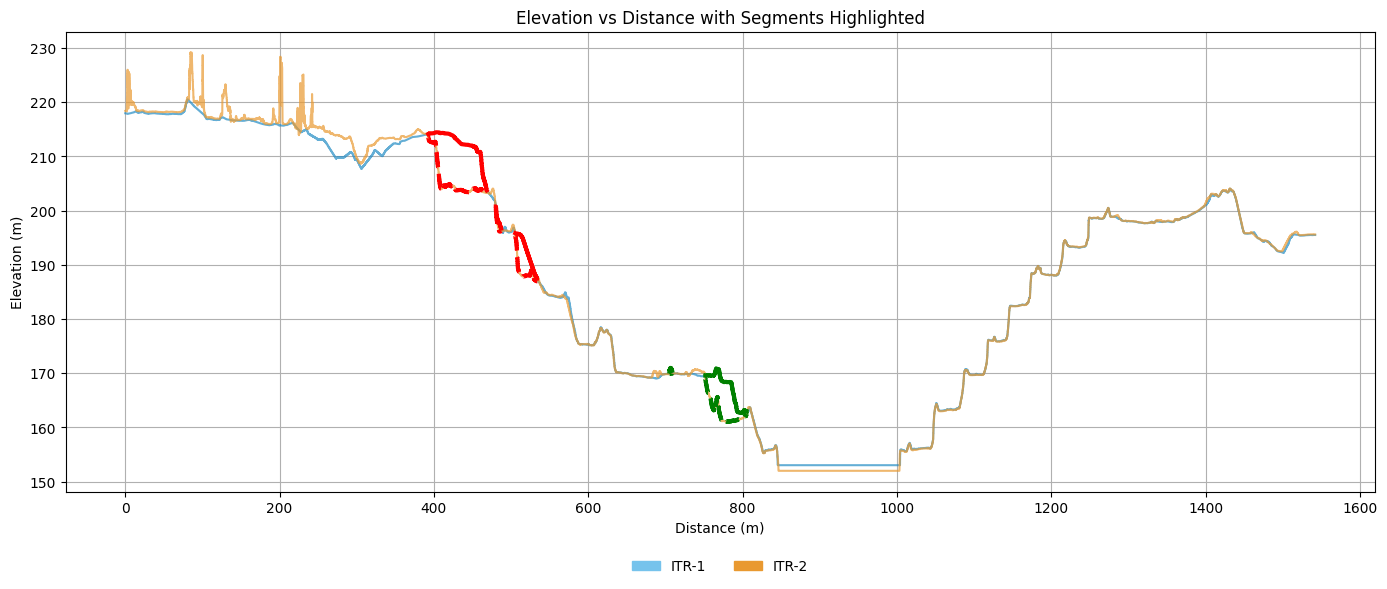

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def plot_two_iterations_with_segments(df1, df2, segment_data_dict,
                                      label1="ITERATION-1", label2="ITERATION-2"):
    """
    Plot two elevation profiles with colored overlays for each segment.
    
    Args:
        df1 (pd.DataFrame): DataFrame with 'chainage' and 'z' columns (Iteration 1).
        df2 (pd.DataFrame): DataFrame with 'chainage' and 'z' columns (Iteration 2).
        segment_data_dict (dict): Dict of {name: (segment_df, color)}.
        label1 (str): Label for first iteration.
        label2 (str): Label for second iteration.
    """
    plt.figure(figsize=(14, 6))
    
    # Plot base elevation profiles (whole section)
    plt.plot(df1["chainage"], df1["z"], color="#238cc4", linewidth=1.5, label=label1, alpha=0.7)
    plt.plot(df2["chainage"], df2["z"], color="#e99930", linewidth=1.5, label=label2, alpha=0.7)
    
    # Overlay each segment as thicker colored lines
    for name, (segment_df, seg_color) in segment_data_dict.items():
        if segment_df is None or segment_df.empty:
            continue
        
        # Segments come as start & end points → iterate in pairs
        for i in range(0, len(segment_df), 2):
            if i + 1 >= len(segment_df):
                continue
            
            ch_start = min(segment_df.iloc[i]["chainage"], segment_df.iloc[i+1]["chainage"])
            ch_end   = max(segment_df.iloc[i]["chainage"], segment_df.iloc[i+1]["chainage"])
            
            # Mask data inside this chainage range
            mask1 = (df1["chainage"] >= ch_start) & (df1["chainage"] <= ch_end)
            mask2 = (df2["chainage"] >= ch_start) & (df2["chainage"] <= ch_end)
            
            plt.plot(df1.loc[mask1, "chainage"], df1.loc[mask1, "z"],
                     color=seg_color, linewidth=3, label=f"{name} itr1" if i == 0 else None)
            plt.plot(df2.loc[mask2, "chainage"], df2.loc[mask2, "z"],
                     color=seg_color, linewidth=3, linestyle="--", label=f"{name} itr2" if i == 0 else None)
    
    # Labels and grid
    plt.xlabel("Distance (m)")
    plt.ylabel("Elevation (m)")
    plt.title("Elevation vs Distance with Segments Highlighted")
    plt.grid(True)

    # Custom legend: iteration boxes + segment lines
    box1 = mpatches.Patch(color="#76c3ec", label=label1)
    box2 = mpatches.Patch(color="#e99930", label=label2)
    plt.legend(handles=[box1, box2], loc="upper center", bbox_to_anchor=(0.5, -0.12),
               ncol=2, frameon=False)
    
    plt.tight_layout()
    plt.show()

plot_two_iterations_with_segments(df1, 
                                  df2, 
                                  segment_data_dict,
                                  label1="ITR-1", label2="ITR-2")